In [1]:
window_size_options = [0.1, 0.2, 0.5, 1] #seconds
generated_data = []

In [2]:
from spectral_decomposition import spectrum

sampling_rate = 1000  # Hz
aperiodic_exponent = 2.0
aperiodic_offset = 2.0
knee = 200
peaks = [{'freq': 12, 'amplitude': 1, 'sigma': 2}]

for i, window in enumerate(window_size_options):
    generated_data.append(spectrum(
        sampling_rate=sampling_rate,
        duration=window,
        aperiodic_exponent=aperiodic_exponent,
        aperiodic_offset=aperiodic_offset,
        knee=knee,
        peaks=peaks,
        average_firing_rate=0,
        random_state=42,
        direct_estimate=True,  # skip empirical PSD
        plot=False
    ))

In [3]:
import scipy
from scipy.signal import windows
from scipy.fft import fft
import numpy as np
import math
import matplotlib.pyplot as plt

def plot_single_taper(spectrum, taper_options, sampling_rate): 
    N = len(spectrum.time_domain.combined_signal)
    fft_result = [0 for i in range(len(taper_options))] 
    for i, taper in enumerate(taper_options):
        tapered_signal = spectrum.time_domain.combined_signal * windows.get_window(taper, N)
        freqs = np.fft.fftfreq(N, d=1/sampling_rate)[1:N//2] # starting from 1 to avoid a divide by 0 error later.
        fft_result[i] = (fft(tapered_signal)[1:N//2] / freqs**2)
        plt.loglog(freqs, np.abs(fft_result[i]), label=taper, linewidth=1, alpha=0.5)
    return (freqs, fft_result)
def plot_multi_taper(spectrum, duration, sampling_rate, isOneTaper=False):
    N = len(spectrum.time_domain.time)
    t_w = N/2 - 1 if (duration*sampling_rate/2>=N/2) else duration*sampling_rate/2
    if isOneTaper:
        L = 1
    else:
        L = math.floor(t_w)-1
        print(L)
    tapered_signal = spectrum.time_domain.combined_signal * windows.dpss(N, t_w, L)
    sum = np.zeros(N//2 - 1)
    freqs = np.fft.fftfreq(N, d=1/sampling_rate)[1:N//2] # starting from 1 to avoid a divide by 0 error later.
    for dpss_taper in tapered_signal:
        fft_result = (fft(dpss_taper)[1:N//2])
        sum = (fft_result) + sum
    fft_result = sum / len(tapered_signal)
    plt.loglog(freqs, np.abs(fft_result), label='DPSS', linewidth=1, alpha=0.5)
    return (freqs, fft_result)


/var/folders/qc/gskc2tx57z1gs3hq4hy86wfc0000gn/T/ipykernel_48393/1188426183.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


498


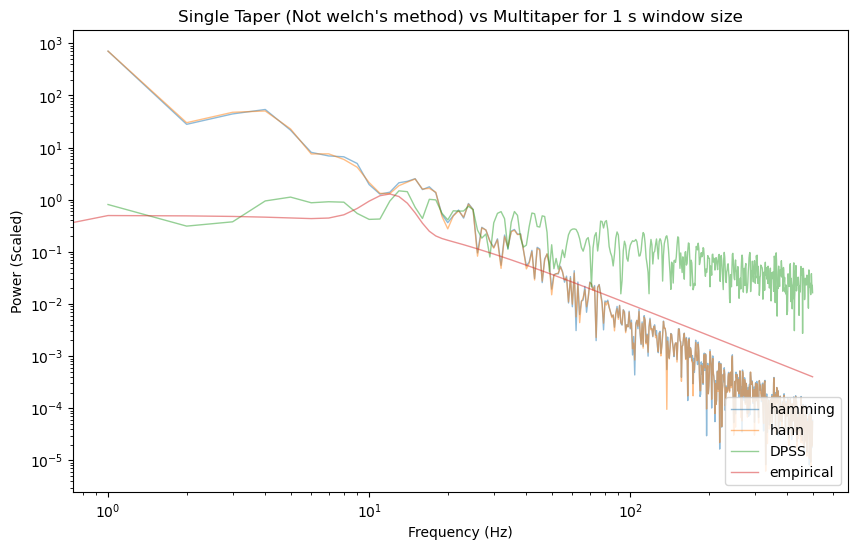

In [4]:
frqs_single, fft_result_single = 0, 0
frqs_multi, fft_result_multi = 0, 0
for i, window in enumerate(window_size_options):
    plt.figure(figsize=(10, 6))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (Scaled)")
    plt.legend(loc="lower right")
    frqs_single, fft_result_single = plot_single_taper(generated_data[i], taper_options=['hamming', 'hann'], sampling_rate=sampling_rate) # TODO, reparse fft_results because right now I'm only running 1 window size
    frqs_multi, fft_result_multi = plot_multi_taper(generated_data[i], duration=window_size_options[i], sampling_rate=sampling_rate, isOneTaper=False)
    plt.loglog(generated_data[i].frequency_domain.combined_spectrum, linewidth=1, alpha=0.5, label='empirical')
    plt.legend(loc="lower right")
    plt.title(f"Single Taper (Not welch's method) vs Multitaper for {window} s window size")

/Users/anikakumar/.local/share/mamb/envs/spectral-decomposition/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/anikakumar/.local/share/mamb/envs/spectral-decomposition/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


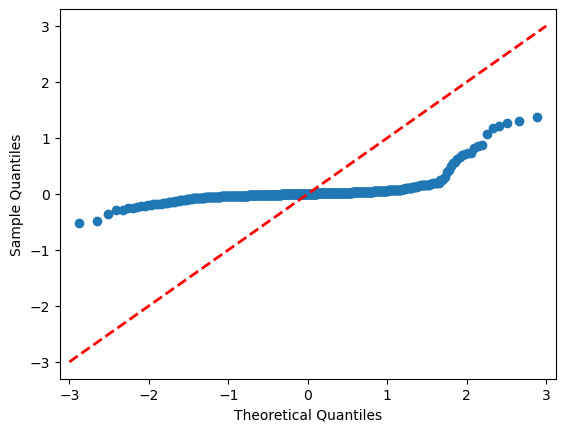

In [6]:
# just trying something, may not be appropriate to do a QQ plot in this context but I think they did it in the paper?
# not sure why it's so bad or if it's expected to be this bad.
import scipy.stats as stats
import statsmodels.api as sm
residuals = generated_data[0].frequency_domain.combined_spectrum[1:500] - fft_result_multi
fig = sm.qqplot(residuals)
plt.plot(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), 'r--', lw=2)
plt.show()